# Table of final train/test accuracies

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

import time
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from spectral_adversarial_regularization import dl_utils
from spectral_adversarial_regularization import adversarial as ad
from spectral_adversarial_regularization.models import *

%matplotlib inline

In [3]:
from get_cifar10 import get_cifar10_dataset

# Load dataset
n_samps = 50000
num_classes = 10

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}

data = {
    'true': (data['true'][0], data['true'][1], data['true'][2][500:], data['true'][3][500:]),
    'rand': (data['rand'][0], data['rand'][1], data['rand'][2][500:], data['rand'][3][500:])
}


data_small = {
    'true': (data['true'][0][:1000], data['true'][1][:1000], data['true'][2][:1000], data['true'][3][:1000]),
    'rand': (data['rand'][0][:1000], data['rand'][1][:1000], data['rand'][2][:1000], data['rand'][3][:1000])
}

In [24]:
def get_train_test(Xtr, Ytr, Xtt, Ytt, save_dir, arch):
    acc_train = dl_utils.build_graph_and_predict(Xtr, save_dir, arch=arch, Y=Ytr)
    acc_test = dl_utils.build_graph_and_predict(Xtt, save_dir, arch=arch, Y=Ytt)
    return acc_train, acc_test

def sort_func(fname):
    if 'wd' not in fname:
        return (-1, fname)
    return (float(fname.split('wd')[1]), fname)

def get_all_accs(data, arch_name, models):
    
    out_dict = {
        'arch_names_true':[arch_name],
        'arch_names_rand':[arch_name],
        'train_acc_true': [],
        'test_acc_true': [],
        'train_acc_rand': [],
        'test_acc_rand': []
    }
    
    main_dir = 'save_weights_n50000_%s_tightsn'%(arch_name)
    
    for j, i in enumerate(data.keys()):

        Xtr, Ytr, Xtt, Ytt = data[i]

        save_dir = 'save_weights_n50000_%s/%s_%s/'%(arch_name, arch_name, i)
        acc_train, acc_test = get_train_test(Xtr, Ytr, Xtt, Ytt, save_dir, arch=models['default'])
        out_dict['train_acc_%s'%(i)].append(acc_train)
        out_dict['test_acc_%s'%(i)].append(acc_test)

        for f in sorted(os.listdir(main_dir), key=sort_func):

            if i in f:
                name = f.replace('_rand', '').replace('_true', '')
                out_dict['arch_names_%s'%(i)].append(name)
                save_dir = os.path.join(main_dir, f)
                acc_train, acc_test = get_train_test(Xtr, Ytr, Xtt, Ytt, save_dir, models[f.split('_')[2]])
                out_dict['train_acc_%s'%(i)].append(acc_train)
                out_dict['test_acc_%s'%(i)].append(acc_test)
            
    return out_dict

def visualize_results(out_dict):
    
    for label_type in ['true', 'rand']:
    
        out_temp = {i: out_dict[i] for i in out_dict if label_type in i}
        
        display(pd.DataFrame.from_dict(out_temp))

        plt.figure(figsize=(10, 7))
        wd = [i.split('wd')[1] for i in out_temp['arch_names_%s'%(label_type)][3:]]
        for k in out_temp:
            if 'arch_names' not in k:
                plt.plot(wd, out_temp[k][3:], label=k)
        plt.xlabel('weight decay on last layer')
        plt.xscale('log')
        plt.ylabel('accuracy')
        plt.title(label_type)
        plt.grid()
        plt.legend()
        plt.show()

In [23]:
arch_name = 'alexnet'

models = {
    'default': alexnet.alexnet,
    'sn': alexnet_tightsn.alexnet_sn,
    'sar': alexnet_tightsn.alexnet_sar
}

out_dict = get_all_accs(data_small, arch_name, models)

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand/checkpoints/epoch80
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand/checkpoints/epoch80
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_rand_sn/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_rand_sn/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_rand_sar_wd0/checkpoints/epoch234
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_rand_sar_wd0/checkpoints/epoch234
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_rand_sar_wd4e-05/checkpoints/epoch249
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_rand_sar_wd4e-05/checkpoints/epoch249
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tights

,arch_names,test_acc_rand,test_acc_true,train_acc_rand,train_acc_true
0,alexnet,0.122,0.777,0.999,0.998
1,alexnet_sn,0.114,0.635,0.383,0.671
2,alexnet_sar_wd0,0.100,0.797,1.000,1.000
3,alexnet_sar_wd4e-05,0.087,0.788,0.999,1.000
4,alexnet_sar_wd0.0004,0.100,0.793,0.991,0.996
5,alexnet_sar_wd0.004,0.099,0.733,0.632,0.860
6,alexnet_sar_wd0.0075,0.098,0.715,0.450,0.791
7,alexnet_sar_wd0.01,0.106,0.703,0.370,0.757
8,alexnet_sar_wd0.025,0.114,0.646,0.158,0.692
9,alexnet_sar_wd0.04,0.102,0.628,0.117,0.646


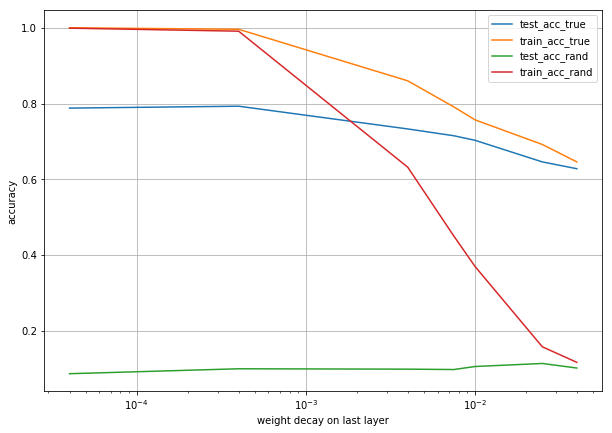

In [39]:
visualize_results(out_dict)

In [16]:
arch_name = 'inception'

models = {
    'default': inception.inception,
    'sn': inception_tightsn.inception_sn,
    'sar': inception_tightsn.inception_sar
}

out_dict = get_all_accs(data_small, arch_name, models)

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand/checkpoints/epoch183
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand/checkpoints/epoch183
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_rand_sn/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_rand_sn/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_rand_sar_wd0/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_rand_sar_wd0/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_rand_sar_wd4e-05/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_rand_sar_wd4e-05/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from 

,arch_names_true,test_acc_true,train_acc_true
0,inception,0.850,0.998
1,inception_sn,0.830,0.998
2,inception_sar_wd0,0.839,1.000
3,inception_sar_wd4e-05,0.842,1.000
4,inception_sar_wd0.0004,0.830,0.998
5,inception_sar_wd0.004,0.833,0.998
6,inception_sar_wd0.04,0.807,0.953
7,inception_sar_wd0.075,0.810,0.921
8,inception_sar_wd0.1,0.812,0.915
9,inception_sar_wd0.25,0.799,0.850


,arch_names_rand,test_acc_rand,train_acc_rand
0,inception,0.120,0.996
1,inception_sn,0.091,0.093
2,inception_sar_wd0,0.091,0.093
3,inception_sar_wd4e-05,0.091,0.093
4,inception_sar_wd0.0004,0.091,0.093
5,inception_sar_wd0.004,0.091,0.093
6,inception_sar_wd0.04,0.091,0.093


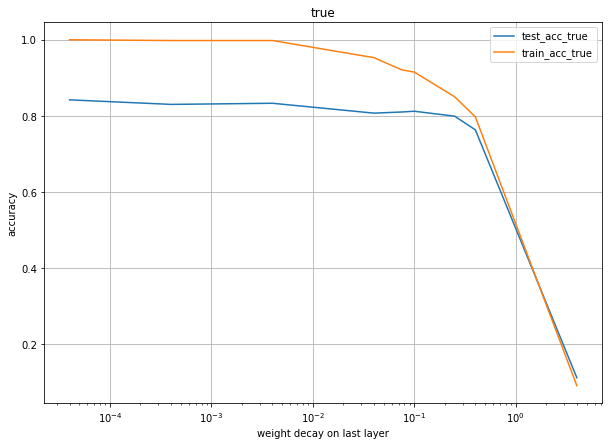

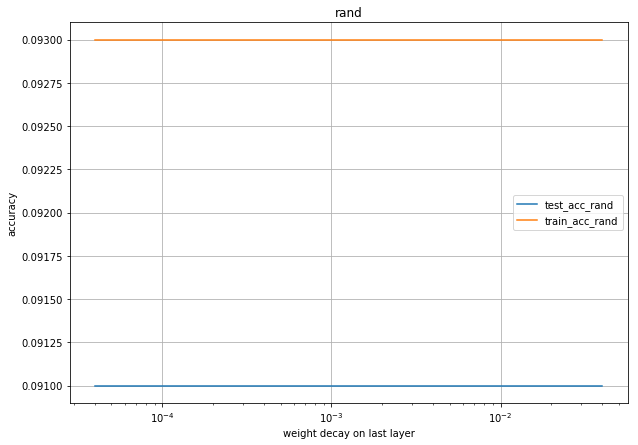

In [25]:
visualize_results(out_dict)

In [26]:
arch_name = 'vgg'

models = {
    'default': vgg.vgg,
    'sn': vgg_tightsn.vgg_sn,
    'sar': vgg_tightsn.vgg_sar
}

out_dict = get_all_accs(data_small, arch_name, models)

INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_rand/checkpoints/epoch58
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_rand/checkpoints/epoch58
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_rand_sn/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_rand_sn/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_rand_sar_wd0/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_rand_sar_wd0/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_rand_sar_wd4e-05/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_rand_sar_wd4e-05/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
INFO:tensorflow:Restoring parameters from sav

,arch_names_true,test_acc_true,train_acc_true
0,vgg,0.784,0.982
1,vgg_sn,0.560,0.543
2,vgg_sar_wd0,0.741,0.991
3,vgg_sar_wd4e-05,0.754,0.999
4,vgg_sar_wd0.0004,0.743,0.936
5,vgg_sar_wd0.00075,0.726,0.875
6,vgg_sar_wd0.001,0.705,0.826
7,vgg_sar_wd0.0025,0.660,0.706
8,vgg_sar_wd0.004,0.587,0.588
9,vgg_sar_wd0.04,0.111,0.090


,arch_names_rand,test_acc_rand,train_acc_rand
0,vgg,0.103,1.000
1,vgg_sn,0.091,0.093
2,vgg_sar_wd0,0.091,0.093
3,vgg_sar_wd4e-05,0.091,0.093


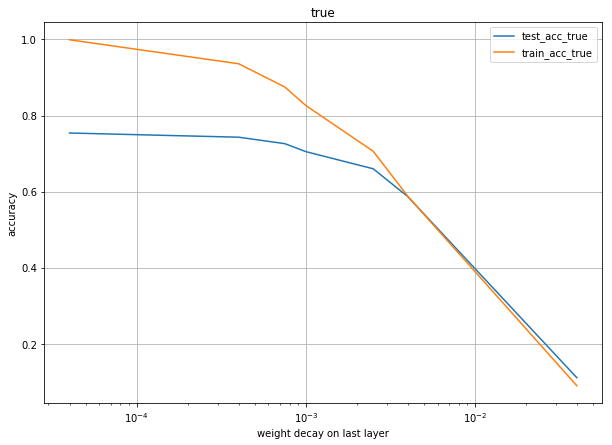

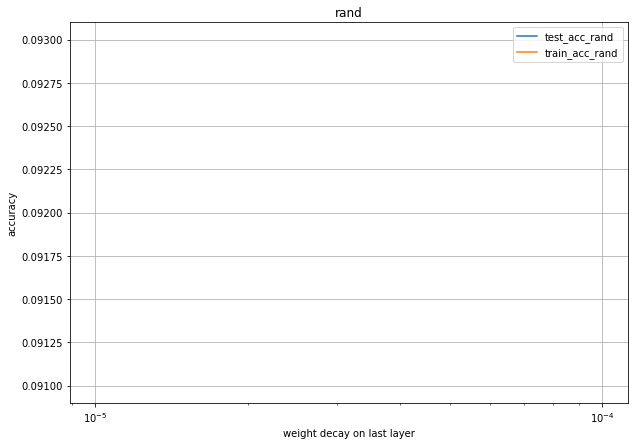

In [27]:
visualize_results(out_dict)